In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

## Spending Data Processing

Two data files were used to retrieve data on the spending rates of on Education. One data file records spending rate from the public field, and the other from the private field. This gives a better indication of the graduation rate, as the graduation rates may be affected by overall spending on Education.
Some countries in the data had to be exluded as the percentage spending on GDP was too great with values between 500-4000% spending on education, which is likely caused by decimal error. Including such data would make comparing with other countries impossible, as spending percentages on average were around 9% of the GDP. These data were excluded by using a 99.99% Confidence Interval.
Time dates were taken from 2000 onwards, to match the data collected for graduation.

Only data for spending on Primary and Secondary education were used, as spending on tertiary education may have increase complexity as to which field on the education the money was invested in, and graduation would also be affected by the field the students decide to enrol in.

Eventually data from the two files were filtered and grouped to include Location, Time, private_spending, public_spending, and overall_spending.

In [2]:
private_spending_file = 'Private_Expendiature_Education.csv'
public_spending_file = 'Public_Expenditure_Education.csv'

private_spending = pd.read_csv(private_spending_file)
public_spending = pd.read_csv(public_spending_file)

# Filter out data if spending is in Tertiary Education
public_spending_notry = public_spending[public_spending['SUBJECT'].isin(['PRY', 'PRY_NTRY', 'SRY'])]
table_public = public_spending_notry.groupby(['LOCATION', 'TIME'])['Value'].sum().reset_index()

# Filter extreme values for public spending
lower_threshold_public = table_public['Value'].quantile(0.01)
upper_threshold_public = table_public['Value'].quantile(0.99)

table_public_filtered = table_public[
    (table_public['Value'] > lower_threshold_public) &
    (table_public['Value'] < upper_threshold_public)
]

# Do the same for private spending
private_spending_notry = private_spending[private_spending['SUBJECT'].isin(['PRY', 'PRY_NTRY', 'SRY', 'EARLYCHILDEDU'])]
table_private = private_spending_notry.groupby(['LOCATION', 'TIME'])['Value'].sum().reset_index()

# Filter extreme values for private spending
lower_threshold_private = table_private['Value'].quantile(0.01)
upper_threshold_private = table_private['Value'].quantile(0.99)

table_private_filtered = table_private[
    (table_private['Value'] > lower_threshold_private) &
    (table_private['Value'] < upper_threshold_private)
]

# Combine the data from private and public
spending_table = pd.merge(table_private_filtered, table_public_filtered, on=['LOCATION', 'TIME'], suffixes=('_private', '_public'), how='outer')
spending_table = spending_table.fillna(0)
spending_table = spending_table[spending_table['TIME'] >= 2000]

# Create a column for total spending (public and private)
spending_table['Total_Spending'] = spending_table['Value_private'] + spending_table['Value_public']

# Select relevant columns in the final result
total_spending_table = spending_table[['LOCATION', 'TIME', 'Value_private', 'Value_public', 'Total_Spending']]
display(total_spending_table)
display(total_spending_table['LOCATION'].unique())

,LOCATION,TIME,Value_private,Value_public,Total_Spending
0,ARG,2000,0.897965,3.249727,4.147692
1,ARG,2008,0.627962,3.561938,4.189901
2,ARG,2009,0.665735,4.022185,4.687920
3,ARG,2010,0.830049,3.636445,4.466494
4,ARG,2011,0.739418,3.825775,4.565194
...,...,...,...,...,...
657,TUR,2009,0.000000,2.351217,2.351217
658,TUR,2010,0.000000,2.357364,2.357364
659,ZAF,2017,0.000000,4.061841,4.061841
660,ZAF,2018,0.000000,4.148211,4.148211


array(['ARG', 'AUS', 'AUT', 'BEL', 'BGR', 'CAN', 'CHE', 'CHL', 'COL',
       'CRI', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR',
       'GRC', 'HRV', 'HUN', 'IND', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN',
       'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'NZL', 'OAVG',
       'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'USA',
       'BRA', 'G20', 'IDN', 'ZAF'], dtype=object)

## Graduation Data Processing

As mentioned above, only Primary and Secondary graduation rates have been observed in the dataset. This allows for the observation of education levels as a baseline, not taking into account the field of study of the student, nor enrollment into different countries, decisions not to enroll in tertiary education etc. 
Here the mean percentage of graduation was taken 

In [3]:
graduation_file = 'Secondary_graduation.csv'
df_graduation = pd.read_csv(graduation_file)

df_graduation_filtered = df_graduation[df_graduation['SUBJECT'].isin(['UPPSRY'])]
df_graduation_mean = df_graduation_filtered.groupby(['LOCATION', 'TIME'])['Value'].mean().reset_index()
df_graduation_mean = df_graduation_mean[['LOCATION', 'TIME', 'Value']]

spending_graduation_table = pd.merge(total_spending_table, df_graduation_mean, on=['TIME', 'LOCATION'], how='left')

spending_graduation_table = spending_graduation_table.rename(columns={
    'LOCATION': 'Country_Code',
    'TIME': 'Year',
    'Value_private': 'Private_Spending',
    'Value_public': 'Public_Spending',
    'Total_Spending': 'Total_Spending',
    'Value': 'Mean_Graduation_Value'
})
spending_graduation_table_nomissing = spending_graduation_table.dropna()

display(spending_graduation_table_nomissing)
display(spending_graduation_table_nomissing['Country_Code'].unique())

,Country_Code,Year,Private_Spending,Public_Spending,Total_Spending,Mean_Graduation_Value
20,AUT,2012,0.342346,2.993731,3.336077,84.955
21,AUT,2013,0.343512,3.071253,3.414765,83.765
22,AUT,2014,0.362508,2.979963,3.342471,83.544
23,AUT,2015,0.376884,2.980174,3.357058,84.035
24,AUT,2016,0.378572,2.988191,3.366763,80.558
...,...,...,...,...,...,...
632,PRT,2011,0.000000,3.559069,3.559069,66.899
633,SWE,2011,0.000000,3.615736,3.615736,75.434
634,SWE,2012,0.000000,3.649807,3.649807,77.126
635,TUR,2005,0.000000,1.906139,1.906139,47.549


array(['AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'COL', 'CZE', 'DEU', 'DNK',
       'ESP', 'EST', 'FIN', 'GBR', 'GRC', 'HUN', 'IRL', 'ISL', 'ISR',
       'ITA', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR', 'NZL',
       'OAVG', 'POL', 'PRT', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'BRA',
       'CRI'], dtype=object)

## Plot the tables


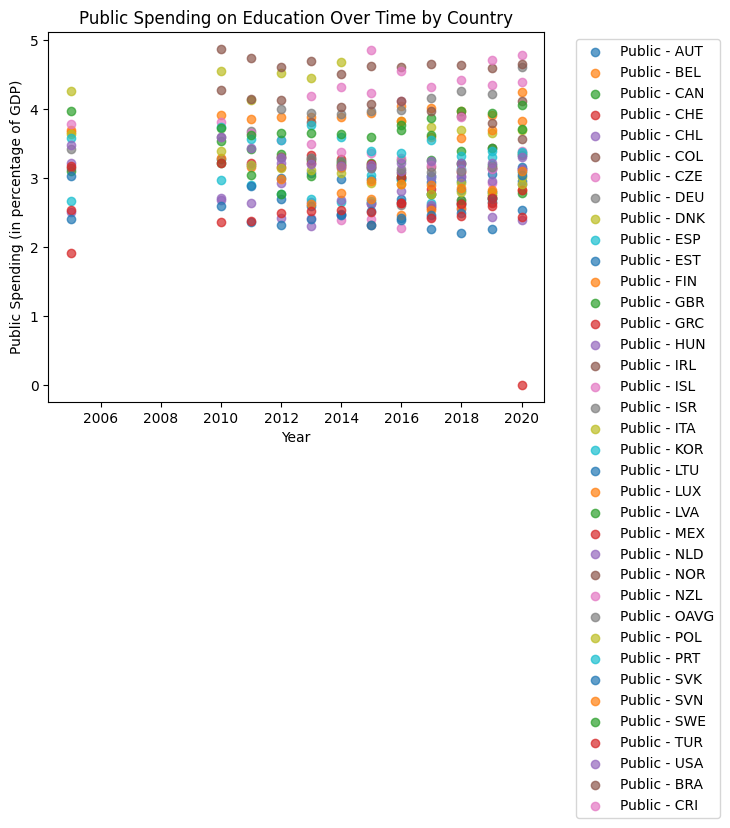

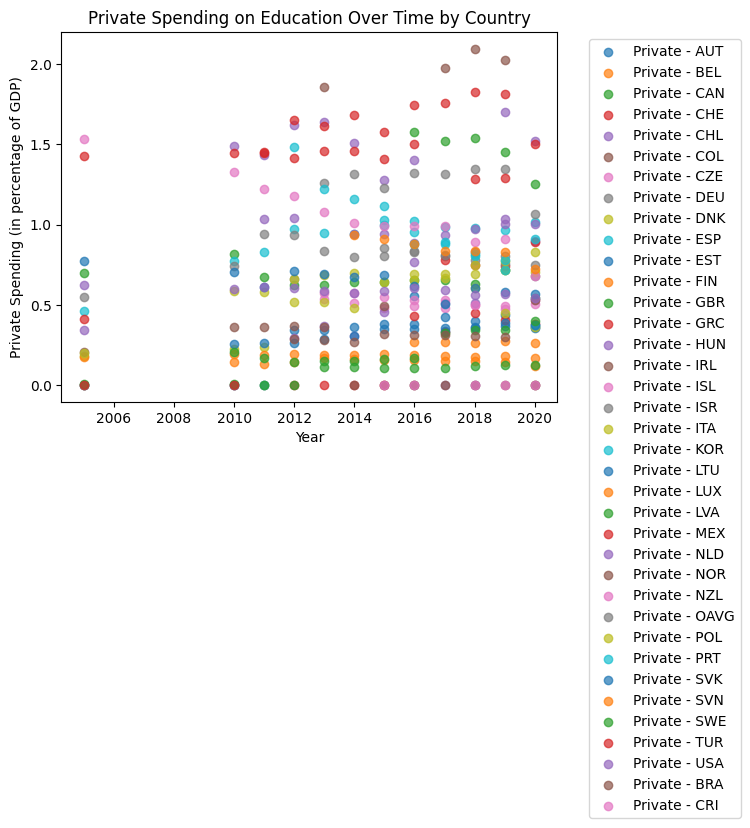

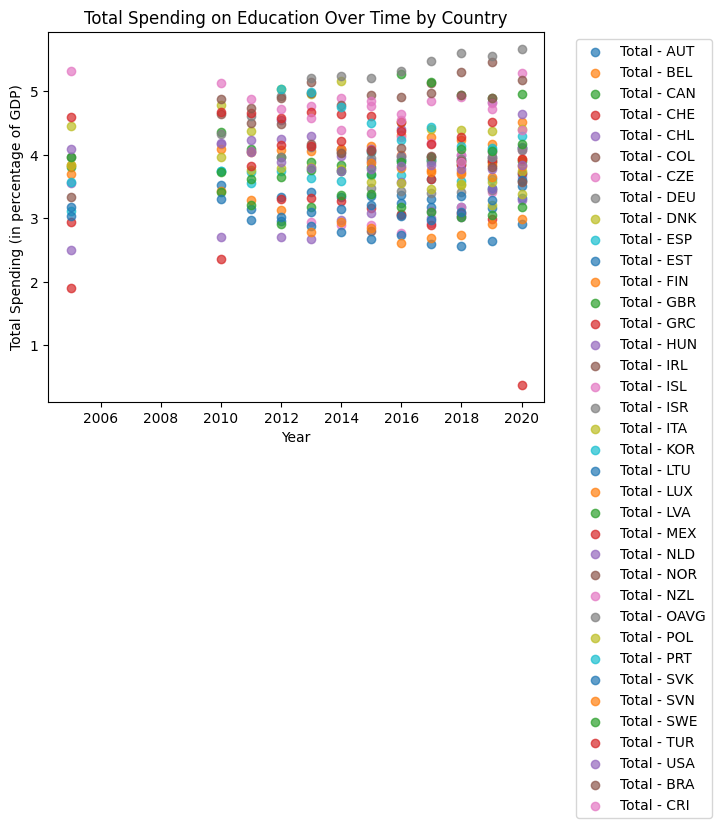

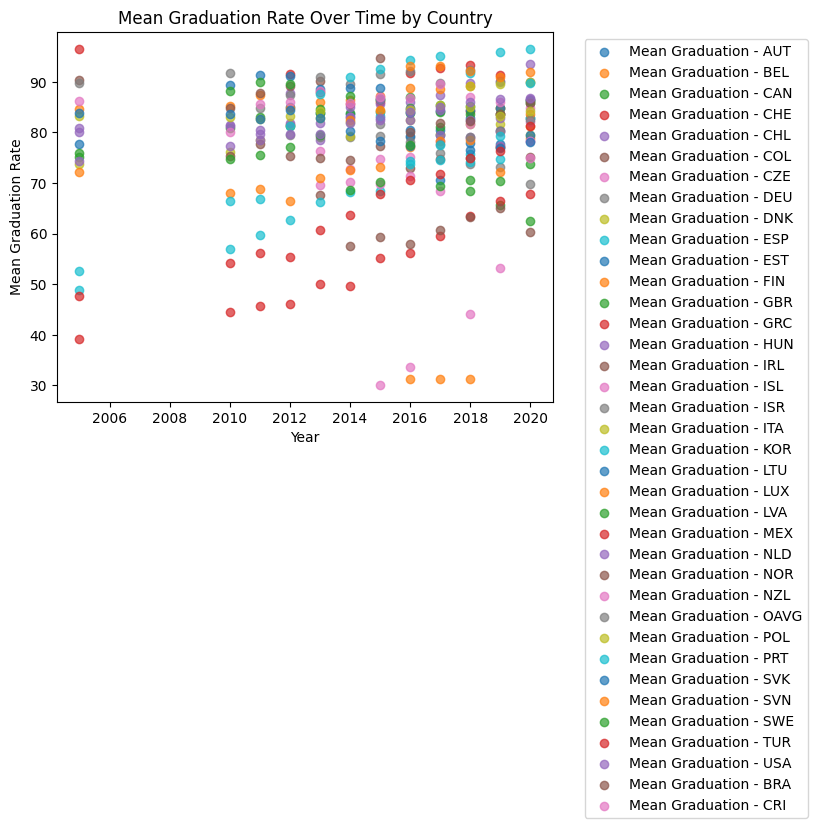

In [4]:
countries = spending_graduation_table_nomissing['Country_Code'].unique()

# scatter plots for public spending
for country in countries:
    country_data = spending_graduation_table_nomissing[spending_graduation_table_nomissing['Country_Code'] == country]
    plt.scatter(country_data['Year'], country_data['Public_Spending'], label=f'Public - {country}', marker='o', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Public Spending (in percentage of GDP)')
plt.title('Public Spending on Education Over Time by Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# scatter plots for private spending
for country in countries:
    country_data = spending_graduation_table_nomissing[spending_graduation_table_nomissing['Country_Code'] == country]
    plt.scatter(country_data['Year'], country_data['Private_Spending'], label=f'Private - {country}', marker='o', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Private Spending (in percentage of GDP)')
plt.title('Private Spending on Education Over Time by Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# scatter plots for total spending
for country in countries:
    country_data = spending_graduation_table_nomissing[spending_graduation_table_nomissing['Country_Code'] == country]
    plt.scatter(country_data['Year'], country_data['Total_Spending'], label=f'Total - {country}', marker='o', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Total Spending (in percentage of GDP)')
plt.title('Total Spending on Education Over Time by Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# scatter plots for mean graduation rate
for country in countries:
    country_data = spending_graduation_table_nomissing[spending_graduation_table_nomissing['Country_Code'] == country]
    plt.scatter(country_data['Year'], country_data['Mean_Graduation_Value'], label=f'Mean Graduation - {country}', marker='o', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Mean Graduation Rate')
plt.title('Mean Graduation Rate Over Time by Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Analyse Affect of Spending on Education with Graduation Rates

Total Spending:-5.94e-05

The correlation is very close to zero, indicating a very weak or negligible linear relationship between graduation percentage and total spending. The negative sign suggests a very slight negative correlation.

Correlation with Private Spending:0.221

The positive correlation of 0.221 suggests a weak positive linear relationship between graduation percentage and private spending. As private spending increases, graduation percentage tends to increase, but the relationship is not very strong.

Correlation with Public Spending: -0.182

The negative correlation of -0.182 suggests a weak negative linear relationship between graduation percentage and public spending. As public spending increases, graduation percentage tends to decrease slightly, but again, the relationship is not very strong.


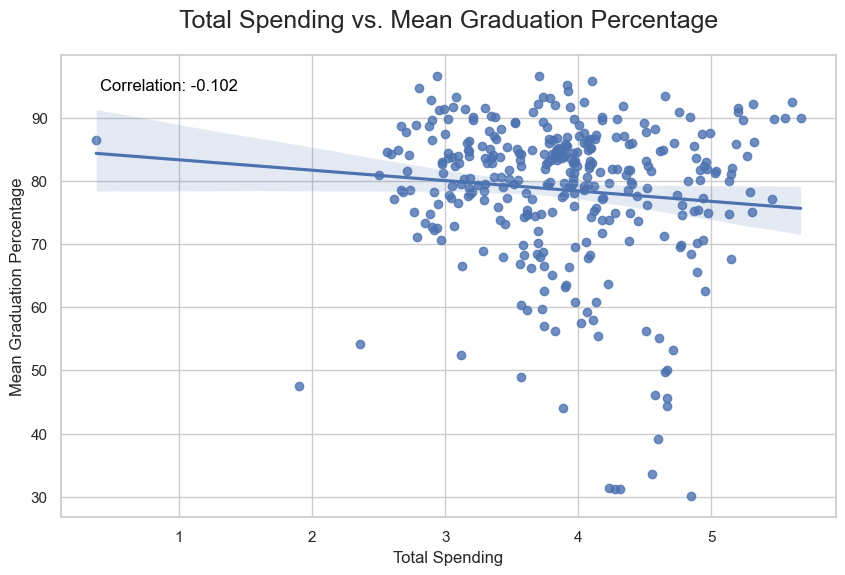

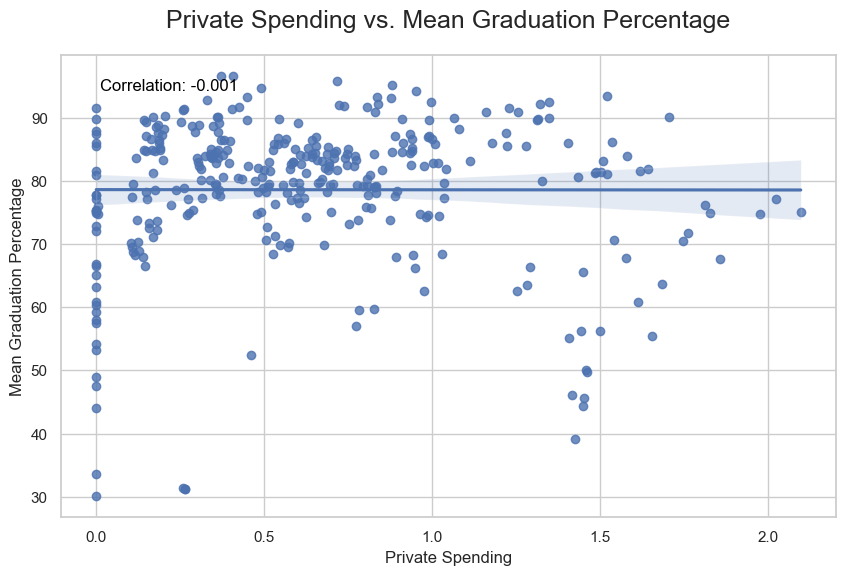

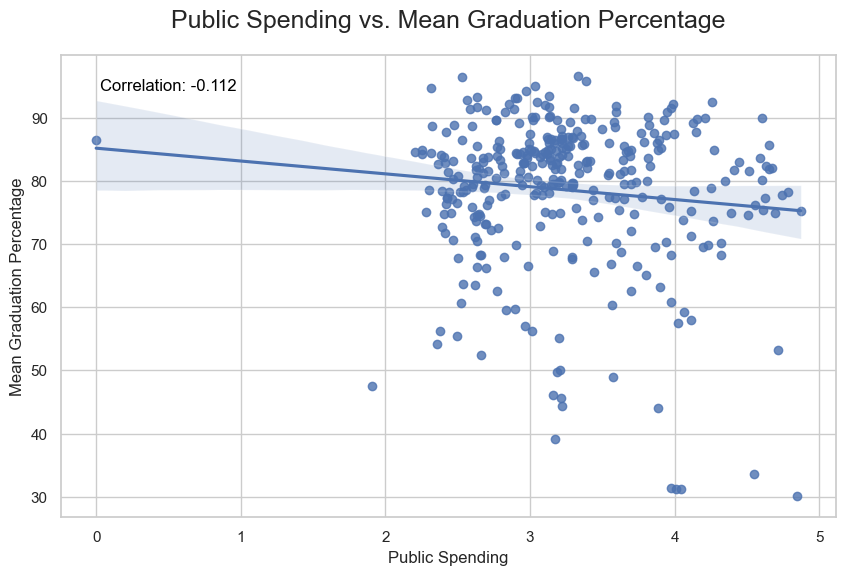

In [5]:
correlation_total_spending = spending_graduation_table_nomissing['Mean_Graduation_Value'].corr(spending_graduation_table_nomissing['Total_Spending'])
correlation_private_spending = spending_graduation_table_nomissing['Mean_Graduation_Value'].corr(spending_graduation_table_nomissing['Private_Spending'])
correlation_public_spending = spending_graduation_table_nomissing['Mean_Graduation_Value'].corr(spending_graduation_table_nomissing['Public_Spending'])

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Function to add correlation values to the plots
def annotate_correlation(ax, correlation_value):
    ax.annotate(f'Correlation: {correlation_value:.3f}', 
                xy=(0.05, 0.95), 
                xycoords='axes fraction', 
                ha='left', va='top', 
                fontsize=12, color='black')

# Function to set the title with bigger font size and space
def set_title(ax, title, title_fontsize):
    ax.set_title(title, fontsize=title_fontsize, pad=20)

# Scatter plot for Total Spending vs. Graduation
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='Total_Spending', y='Mean_Graduation_Value', data=spending_graduation_table)
annotate_correlation(ax, correlation_total_spending)
set_title(ax, 'Total Spending vs. Mean Graduation Percentage', title_fontsize=18)
plt.xlabel('Total Spending')
plt.ylabel('Mean Graduation Percentage')
plt.show()

# Scatter plot for Private Spending vs. Graduation
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='Private_Spending', y='Mean_Graduation_Value', data=spending_graduation_table)
annotate_correlation(ax, correlation_private_spending)
set_title(ax, 'Private Spending vs. Mean Graduation Percentage', title_fontsize=18)
plt.xlabel('Private Spending')
plt.ylabel('Mean Graduation Percentage')
plt.show()

# Scatter plot for Public Spending vs. Graduation
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='Public_Spending', y='Mean_Graduation_Value', data=spending_graduation_table)
annotate_correlation(ax, correlation_public_spending)
set_title(ax, 'Public Spending vs. Mean Graduation Percentage', title_fontsize=18)
plt.xlabel('Public Spending')
plt.ylabel('Mean Graduation Percentage')
plt.show()